<a href="https://colab.research.google.com/github/TZS3138/your-repo/blob/main/02_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Dec 30 20:15:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
!pip install matplotlib numpy tqdm

Looking in indexes: https://download.pytorch.org/whl/cu124


**Part 2**

1. Transfer Learning Model

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.optim import lr_scheduler
import os

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cu126
CUDA available: True


In [4]:
# Train Augmentations
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Validation & Test Augmentations
val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Re-load Datasets with Specific Transforms
train_set = datasets.Flowers102(root="./data", split="train", download=True, transform=train_transforms)
val_set = datasets.Flowers102(root="./data", split="val", download=True, transform=val_test_transforms)
test_set = datasets.Flowers102(root="./data", split="test", download=True, transform=val_test_transforms)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 345M/345M [00:16<00:00, 21.5MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.23MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 48.0MB/s]


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def initialize_model(num_classes=102):
    # Load pre-trained EfficientNet-B0
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

    # Freeze Backbone
    # To prevent the model from forgetting the basic features during the initial training phase
    for param in model.parameters():
        param.requires_grad = False

    # Replace the Classifier
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(num_ftrs, num_classes)
    )

    return model.to(device)

model = initialize_model()

# Optimiser
# CrossEntropy handles multi-class, monitor for imbalance in training metrics
# Adam Optimiser ensure the stable of pre-trained weights
# LR=0.01, LR=0.001, LR=0.0001 are run
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)

# Learning Rate Scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 158MB/s]


ResNet and EfficientNet both work well with small scale data. However, EfficientNet uses compound scaling to balance depth, width, and resolution, which consistently outperforming ResNet in accuracy while using fewer parameters.

ViT is suitable for large scale data and is resource heavy. The Oxford 102 Flowers dataset that contains 8189 images is relatively small which can prone to overfitting.

Overall, EfficientNet is the most efficient in term of best accuracy and resource ratio where free tier Google Colab is used.

2. Training Infrastructure

In [6]:
import os
import time
import copy
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import torch
import pickle
from google.colab import drive

save_dir = '/content/results/'
os.makedirs(save_dir, exist_ok=True)

Epoch 0/19
----------


100%|██████████| 32/32 [00:08<00:00,  3.92it/s]


train Loss: 4.5089 Acc: 0.0608


100%|██████████| 32/32 [00:06<00:00,  5.24it/s]


val Loss: 3.9012 Acc: 0.3725

Epoch 1/19
----------


100%|██████████| 32/32 [00:06<00:00,  4.75it/s]


train Loss: 3.6131 Acc: 0.3941


100%|██████████| 32/32 [00:05<00:00,  6.20it/s]


val Loss: 3.2611 Acc: 0.5980

Epoch 2/19
----------


100%|██████████| 32/32 [00:07<00:00,  4.50it/s]


train Loss: 3.0027 Acc: 0.5922


100%|██████████| 32/32 [00:05<00:00,  6.14it/s]


val Loss: 2.7511 Acc: 0.6804

Epoch 3/19
----------


100%|██████████| 32/32 [00:07<00:00,  4.27it/s]


train Loss: 2.5124 Acc: 0.6608


100%|██████████| 32/32 [00:05<00:00,  6.13it/s]


val Loss: 2.3847 Acc: 0.7167

Epoch 4/19
----------


100%|██████████| 32/32 [00:07<00:00,  4.41it/s]


train Loss: 2.1345 Acc: 0.7235


100%|██████████| 32/32 [00:05<00:00,  6.36it/s]


val Loss: 2.0863 Acc: 0.7451

Epoch 5/19
----------


100%|██████████| 32/32 [00:07<00:00,  4.24it/s]


train Loss: 1.8709 Acc: 0.7647


100%|██████████| 32/32 [00:04<00:00,  6.44it/s]


val Loss: 1.8622 Acc: 0.7716

Epoch 6/19
----------


100%|██████████| 32/32 [00:07<00:00,  4.34it/s]


train Loss: 1.6705 Acc: 0.7657


100%|██████████| 32/32 [00:04<00:00,  6.40it/s]


val Loss: 1.6889 Acc: 0.7735

Epoch 7/19
----------


100%|██████████| 32/32 [00:07<00:00,  4.50it/s]


train Loss: 1.5497 Acc: 0.8010


100%|██████████| 32/32 [00:05<00:00,  6.38it/s]


val Loss: 1.6675 Acc: 0.7824

Epoch 8/19
----------


100%|██████████| 32/32 [00:07<00:00,  4.39it/s]


train Loss: 1.5383 Acc: 0.7824


100%|██████████| 32/32 [00:05<00:00,  6.31it/s]


val Loss: 1.6507 Acc: 0.7863

Epoch 9/19
----------


100%|██████████| 32/32 [00:07<00:00,  4.34it/s]


train Loss: 1.5189 Acc: 0.8049


100%|██████████| 32/32 [00:04<00:00,  6.48it/s]


val Loss: 1.6271 Acc: 0.7814

Epoch 10/19
----------


100%|██████████| 32/32 [00:07<00:00,  4.29it/s]


train Loss: 1.5317 Acc: 0.7824


100%|██████████| 32/32 [00:04<00:00,  6.49it/s]


val Loss: 1.6381 Acc: 0.7902

Epoch 11/19
----------


100%|██████████| 32/32 [00:07<00:00,  4.38it/s]


train Loss: 1.5194 Acc: 0.7941


100%|██████████| 32/32 [00:05<00:00,  6.39it/s]


val Loss: 1.6104 Acc: 0.7902

Epoch 12/19
----------


100%|██████████| 32/32 [00:07<00:00,  4.52it/s]


train Loss: 1.4918 Acc: 0.8108


100%|██████████| 32/32 [00:05<00:00,  6.23it/s]


val Loss: 1.5418 Acc: 0.7922

Epoch 13/19
----------


100%|██████████| 32/32 [00:06<00:00,  4.79it/s]


train Loss: 1.4724 Acc: 0.7873


100%|██████████| 32/32 [00:05<00:00,  5.73it/s]


val Loss: 1.5925 Acc: 0.7902

Epoch 14/19
----------


100%|██████████| 32/32 [00:06<00:00,  5.04it/s]


train Loss: 1.4960 Acc: 0.7922


100%|██████████| 32/32 [00:05<00:00,  5.47it/s]


val Loss: 1.5624 Acc: 0.7902

Epoch 15/19
----------


100%|██████████| 32/32 [00:06<00:00,  5.08it/s]


train Loss: 1.4902 Acc: 0.7922


100%|██████████| 32/32 [00:06<00:00,  5.22it/s]


val Loss: 1.5737 Acc: 0.7892

Epoch 16/19
----------


100%|██████████| 32/32 [00:06<00:00,  5.24it/s]


train Loss: 1.4606 Acc: 0.7892


100%|██████████| 32/32 [00:06<00:00,  5.27it/s]


val Loss: 1.5861 Acc: 0.7912

Epoch 17/19
----------


100%|██████████| 32/32 [00:06<00:00,  5.15it/s]


train Loss: 1.4313 Acc: 0.8098


100%|██████████| 32/32 [00:06<00:00,  5.28it/s]


val Loss: 1.5829 Acc: 0.7941

Epoch 18/19
----------


100%|██████████| 32/32 [00:06<00:00,  5.21it/s]


train Loss: 1.4665 Acc: 0.8010


100%|██████████| 32/32 [00:06<00:00,  5.29it/s]


val Loss: 1.5352 Acc: 0.7971

Epoch 19/19
----------


100%|██████████| 32/32 [00:06<00:00,  5.29it/s]


train Loss: 1.4751 Acc: 0.8069


100%|██████████| 32/32 [00:06<00:00,  5.25it/s]


val Loss: 1.5995 Acc: 0.8020



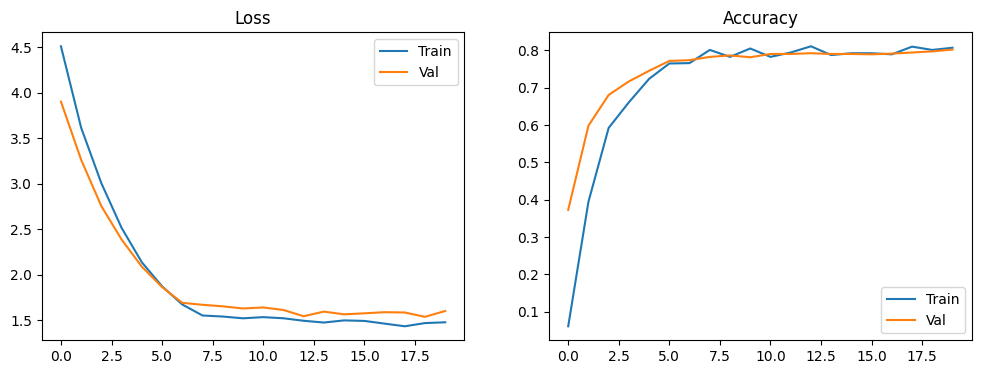

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    since = time.time()

    # Reproducibility
    # Ensure consistent results across different runs
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Early Stopping & Metric Logging
    epochs_no_improve = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloader):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Checkpointing
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), os.path.join(save_dir, 'best_model.pth'))
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch} epochs.")
            break
        print()

    # Save Training History (JSON)
    with open(os.path.join(save_dir, 'training_history.json'), 'w') as f:
        json.dump(history, f)

    # Generate and Save Loss/Accuracy Graphs
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Val')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Val')
    plt.title('Accuracy')
    plt.legend()

    plt.savefig(os.path.join(save_dir, 'training_curves.png'))
    plt.show()

    model.load_state_dict(best_model_wts)
    return model, history

model_ft, training_history = train_model(
    model, criterion, optimizer, exp_lr_scheduler, num_epochs=20, patience=5
)

In [8]:
# Save Data for Part 3
def save_eval_data(model, dataloader, device, save_path):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    eval_data = {'y_true': all_labels, 'y_pred': all_preds, 'y_probs': all_probs}

    with open(os.path.join(save_path, 'eval_results.pkl'), 'wb') as f:
        pickle.dump(eval_data, f)

    print(f"Evaluation data saved to {save_path}")

save_eval_data(model_ft, test_loader, device, save_dir)

Evaluation data saved to /content/results/


In conclusion, 0.01 was too aggressive, causing the loss to oscillate and prevent stable convergence. While 0.0001 was too conservative, leading to extremely slow learning that failed to reach peak performance within the allocated time. However, 0.001 proved to be the most optimal balance, providing the ideal balance of steady loss reduction and high accuracy.